Section 1: Data Loading

In [30]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from sklearn.svm import LinearSVC
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
from bayes_opt import BayesianOptimization
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [31]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [32]:
# read the training and testing files
x_train = pd.read_csv(r"project_data_files/book_rating_train.csv", index_col = False, delimiter = ',', header=0)
x_test = pd.read_csv(r"project_data_files/book_rating_test.csv", index_col = False, delimiter = ',', header=0)

x_train.head(5)

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
0,Best of Dr Jean: Reading & Writing,Jean R. Feldman,2005,6,1,Teaching Resources,NaN,48,Teachers will turn to this treasury of ideas a...,4.0
1,Here All Dwell Free,Gertrud Mueller Nelson,1991,10,1,DoubleDay,NaN,364,Every human being lives a fairy tale -- an unc...,4.0
2,Boomer's Big Surprise,Constance W. McGeorge,2005,3,31,Chronicle Books,NaN,32,<i>Boomer's Big Surprise</i> will have special...,4.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",Carolyn Niethammer,2004,9,1,Bison Books,NaN,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0
4,Us,Richard Mason,2005,7,7,Penguin Books Ltd,eng,352,"Since their days at Oxford, they've gone their...",3.0


In [33]:
# read the doc2vec form of the text features in the dataset
train_name_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
train_authors_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
train_desc_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)

test_name_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/test_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
test_authors_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/test_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
test_desc_vec = pd.read_csv(r"project_data_files/book_text_features_doc2vec/test_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)

Section 2: Descriptive statistics

In [34]:
# Distribution of rating label
rating_distribution = x_train['rating_label'].value_counts()
rating_distribution

languages = x_train['Language'].value_counts(dropna=False)
languages

publishers = x_train['Publisher'].value_counts(dropna=False)
publishers

authors = x_train['Authors'].value_counts(dropna=False)
authors

Anonymous              49
William Shakespeare    48
Carole Mortimer        47
Nora Roberts           47
Agatha Christie        46
                       ..
Arina Tanemura          1
Linda Morse             1
Richard W. Dortch       1
Carol Allain            1
Henry Rollins           1
Name: Authors, Length: 16301, dtype: int64

Section 3: Data cleaning and preprocessing

In [35]:
# deal with blank feature values
x_train.fillna('Unknown', inplace=True)
y_train = x_train['rating_label']

x_test.fillna('Unknown', inplace=True)
x_train.head(5)

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
0,Best of Dr Jean: Reading & Writing,Jean R. Feldman,2005,6,1,Teaching Resources,Unknown,48,Teachers will turn to this treasury of ideas a...,4.0
1,Here All Dwell Free,Gertrud Mueller Nelson,1991,10,1,DoubleDay,Unknown,364,Every human being lives a fairy tale -- an unc...,4.0
2,Boomer's Big Surprise,Constance W. McGeorge,2005,3,31,Chronicle Books,Unknown,32,<i>Boomer's Big Surprise</i> will have special...,4.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",Carolyn Niethammer,2004,9,1,Bison Books,Unknown,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0
4,Us,Richard Mason,2005,7,7,Penguin Books Ltd,eng,352,"Since their days at Oxford, they've gone their...",3.0


In [36]:
# transform all the text-based features using either doc2vec or one-hot encoding
train_publisher = pd.get_dummies(x_train['Publisher'])
train_language = pd.get_dummies(x_train['Language'])
train_publisher
train_language

,Unknown,ara,eng,fre,frs,ger,grc,heb,ita,jpn,lat,mul,nld,per,por,rus,spa,swe,zho
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23059,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23060,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23061,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
test_publisher = pd.get_dummies(x_test['Publisher'])
test_language = pd.get_dummies(x_test['Language'])
test_publisher
test_language

,Unknown,eng,fre,ger,glg,grc,hun,ita,jpn,mul,nld,per,por,rus,spa,swe,tha,urd
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5762,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5764,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# since there are unseen feature values in the test set, make extra encoding
# for both encoded "publisher" and "language" in training and testing sets
train_publisher = pd.concat([train_publisher, 
pd.DataFrame(0, index=train_publisher.index, 
columns=[x for x in list(test_publisher.columns) if x not in list(train_publisher.columns)])], axis=1)

test_publisher = pd.concat([test_publisher, 
pd.DataFrame(0, index=test_publisher.index, 
columns=[x for x in list(train_publisher.columns) if x not in list(test_publisher.columns)])], axis=1)

train_language = pd.concat([train_language, 
pd.DataFrame(0, index=train_language.index, 
columns=[x for x in list(test_language.columns) if x not in list(train_language.columns)])], axis=1)

test_language = pd.concat([test_language, 
pd.DataFrame(0, index=test_language.index, 
columns=[x for x in list(train_language.columns) if x not in list(test_language.columns)])], axis=1)

In [39]:
# combine all the processed features into one complete df for future uses
# below is for testing df
df_test = pd.concat([test_name_vec, test_authors_vec, test_desc_vec], axis=1)
df_test.columns = range(len(df_test.columns))
df_test = pd.concat([df_test, test_language, test_publisher], axis=1)
df_test['pagesNumber'] = x_test['pagesNumber']
df_test['PublishYear'] = x_test['PublishYear']
df_test['PublishMonth'] = x_test['PublishMonth']
df_test['PublishDay'] = x_test['PublishDay']
df_test

,0,1,2,3,4,5,6,7,8,9,...,توپ,نشر ثالث,هرمس,小学館,幻冬舎 / Gentōsha,遠流出版事業股份有限公司,pagesNumber,PublishYear,PublishMonth,PublishDay
0,0.029333,-0.043927,0.102285,-0.121823,-0.016668,-0.137888,-0.059163,0.216625,-0.136272,-0.133504,...,0,0,0,0,0,0,118,1993,1,1
1,0.138439,-0.003614,-0.002051,-0.061709,-0.035443,-0.106722,-0.017021,0.077577,-0.055408,-0.108035,...,0,0,0,0,0,0,32,1997,3,17
2,0.008959,-0.102902,0.100617,-0.217163,0.031681,-0.155196,-0.052115,-0.083774,0.000383,-0.142214,...,0,0,0,0,0,0,544,2005,1,1
3,-0.103115,0.003076,-0.104288,-0.078576,0.094428,-0.073938,0.090622,-0.018610,-0.014757,-0.043682,...,0,0,0,0,0,0,432,2006,9,5
4,-0.377294,-0.037297,0.068795,-0.165371,0.006160,0.058643,0.070002,-0.083565,0.015256,-0.213105,...,0,0,0,0,0,0,352,2002,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,0.137909,0.155925,-0.041329,0.203567,-0.061073,-0.004454,0.011992,0.058941,0.064054,0.197957,...,0,0,0,0,0,0,274,2003,9,1
5762,-0.019626,-0.073607,-0.013475,0.030343,-0.096524,0.074866,-0.025272,-0.014977,0.176195,0.061163,...,0,0,0,0,0,0,224,2004,9,10
5763,-0.176006,0.025466,-0.193973,-0.095170,0.077487,0.044431,0.068534,-0.316328,0.037170,0.198731,...,0,0,0,0,0,0,224,1999,12,14
5764,-0.011545,0.012677,0.032473,0.103847,-0.124135,-0.163065,0.016789,0.164405,0.060370,-0.057711,...,0,0,0,0,0,0,242,1972,6,21


In [40]:
# below is for training df
df_train = pd.concat([train_name_vec, train_authors_vec, train_desc_vec], axis=1)
df_train.columns = range(len(df_train.columns))
df_train = pd.concat([df_train, train_language, train_publisher], axis=1)
df_train['pagesNumber'] = x_train['pagesNumber']
df_train['PublishYear'] = x_train['PublishYear']
df_train['PublishMonth'] = x_train['PublishMonth']
df_train['PublishDay'] = x_train['PublishDay']
df_train

,0,1,2,3,4,5,6,7,8,9,...,Yoda Press,Zebra Historic Fantasy,Zebra Splendor,Zomba Books,dtv Deutscher Taschenbuchverlag,河出書房新社,pagesNumber,PublishYear,PublishMonth,PublishDay
0,0.052262,-0.263308,0.026872,0.128574,-0.161565,-0.127520,0.249588,0.037621,-0.074043,0.072854,...,0,0,0,0,0,0,48,2005,6,1
1,-0.129112,0.021312,0.159166,-0.072448,0.036028,-0.093721,0.129199,0.069736,-0.253263,-0.066424,...,0,0,0,0,0,0,364,1991,10,1
2,-0.170058,0.052351,-0.013406,0.099001,0.083173,-0.161439,0.048635,0.089419,-0.072266,-0.063164,...,0,0,0,0,0,0,32,2005,3,31
3,0.250849,0.021555,0.091047,-0.041589,-0.040949,0.240260,0.415056,0.027029,-0.172413,-0.135485,...,0,0,0,0,0,0,293,2004,9,1
4,-0.041681,0.038051,-0.051164,-0.076813,0.096855,-0.215943,0.152729,0.267636,-0.079954,-0.065560,...,0,0,0,0,0,0,352,2005,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,0.007497,0.000220,0.019723,-0.003321,0.021097,-0.129420,0.130302,-0.037361,-0.004281,-0.255112,...,0,0,0,0,0,0,120,1997,8,1
23059,-0.024484,0.000467,-0.015977,0.086630,0.082127,-0.174537,0.011694,0.111608,-0.106961,-0.147956,...,0,0,0,0,0,0,32,2005,6,1
23060,-0.099309,-0.046230,-0.033294,0.242591,-0.055477,-0.033886,0.026869,0.038410,-0.126636,0.127742,...,0,0,0,0,0,0,132,1989,2,15
23061,-0.038388,0.065679,-0.159324,-0.048682,0.054175,0.317751,0.065931,-0.126021,-0.105057,-0.147185,...,0,0,0,0,0,0,136,1998,4,21


Section 4: Feature Engineering

In [41]:
# First, use information gain to see if there are any attributes not contributing
# to the final labels of the book
def entropy(feature):
    prob = feature.value_counts(normalize=True)
    entropy = -1 * np.sum(prob * np.log2(prob))       
    return entropy

def information_gain(data, label, feature):
    print('Feature:', feature)
    entropy_label = entropy(data[label])
    entropy_list = list()
    prob_list = list()
    for i in data[feature].unique():
        # Calculate H(feature)
        feature_i = data[data[feature] == i]
        entropy_i = entropy(feature_i[label])
        entropy_list.append(entropy_i)
        prob_i = len(feature_i) / len(data)
        prob_list.append(prob_i)
    # Calculate mean information: sum of P(value)*H(value)
    mean_info = np.sum(np.array(entropy_list) * np.array(prob_list))
    information_gain = entropy_label - mean_info
    print('information gain:', information_gain)
    print('====================')
    return(information_gain)

In [42]:
# authors have large branching factor, maybe later find some top authors
# in different selection techniques
for feature in x_train.drop(columns=['Name', 'Authors', 'Description', 'rating_label']).columns:
    feature_info_gain = information_gain(x_train, y_train.name, feature)

Feature: PublishYear
information gain: 0.014102821492525619
Feature: PublishMonth
information gain: 0.0016625179726277306
Feature: PublishDay
information gain: 0.003286848075712445
Feature: Publisher
information gain: 0.31951734938247933
Feature: Language
information gain: 0.008855268387619297
Feature: pagesNumber
information gain: 0.08896965611245478


In [43]:
# from the above results, publish date and language seems to not contribute
# too much to the final labels, so we can discard these features later in modelling
df_test = pd.concat([test_name_vec, test_authors_vec, test_desc_vec], axis=1)
df_test.columns = range(len(df_test.columns))
df_test = pd.concat([df_test, test_publisher], axis=1)
df_test['pagesNumber'] = x_test['pagesNumber']
df_test

,0,1,2,3,4,5,6,7,8,9,...,Éditions Glénat,Éditions P.O.L,تنوير للنشر والإعلام,توپ,نشر ثالث,هرمس,小学館,幻冬舎 / Gentōsha,遠流出版事業股份有限公司,pagesNumber
0,0.029333,-0.043927,0.102285,-0.121823,-0.016668,-0.137888,-0.059163,0.216625,-0.136272,-0.133504,...,0,0,0,0,0,0,0,0,0,118
1,0.138439,-0.003614,-0.002051,-0.061709,-0.035443,-0.106722,-0.017021,0.077577,-0.055408,-0.108035,...,0,0,0,0,0,0,0,0,0,32
2,0.008959,-0.102902,0.100617,-0.217163,0.031681,-0.155196,-0.052115,-0.083774,0.000383,-0.142214,...,0,0,0,0,0,0,0,0,0,544
3,-0.103115,0.003076,-0.104288,-0.078576,0.094428,-0.073938,0.090622,-0.018610,-0.014757,-0.043682,...,0,0,0,0,0,0,0,0,0,432
4,-0.377294,-0.037297,0.068795,-0.165371,0.006160,0.058643,0.070002,-0.083565,0.015256,-0.213105,...,0,0,0,0,0,0,0,0,0,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,0.137909,0.155925,-0.041329,0.203567,-0.061073,-0.004454,0.011992,0.058941,0.064054,0.197957,...,0,0,0,0,0,0,0,0,0,274
5762,-0.019626,-0.073607,-0.013475,0.030343,-0.096524,0.074866,-0.025272,-0.014977,0.176195,0.061163,...,0,0,0,0,0,0,0,0,0,224
5763,-0.176006,0.025466,-0.193973,-0.095170,0.077487,0.044431,0.068534,-0.316328,0.037170,0.198731,...,0,0,0,0,0,0,0,0,0,224
5764,-0.011545,0.012677,0.032473,0.103847,-0.124135,-0.163065,0.016789,0.164405,0.060370,-0.057711,...,0,0,0,0,0,0,0,0,0,242


In [44]:
df_train = pd.concat([train_name_vec, train_authors_vec, train_desc_vec], axis=1)
df_train.columns = range(len(df_train.columns))
df_train = pd.concat([df_train, train_publisher], axis=1)
df_train['pagesNumber'] = x_train['pagesNumber']
df_train

,0,1,2,3,4,5,6,7,8,9,...,YMAA Publication Center,Yeoman House,Yesterday's Classics,Yoda Press,Zebra Historic Fantasy,Zebra Splendor,Zomba Books,dtv Deutscher Taschenbuchverlag,河出書房新社,pagesNumber
0,0.052262,-0.263308,0.026872,0.128574,-0.161565,-0.127520,0.249588,0.037621,-0.074043,0.072854,...,0,0,0,0,0,0,0,0,0,48
1,-0.129112,0.021312,0.159166,-0.072448,0.036028,-0.093721,0.129199,0.069736,-0.253263,-0.066424,...,0,0,0,0,0,0,0,0,0,364
2,-0.170058,0.052351,-0.013406,0.099001,0.083173,-0.161439,0.048635,0.089419,-0.072266,-0.063164,...,0,0,0,0,0,0,0,0,0,32
3,0.250849,0.021555,0.091047,-0.041589,-0.040949,0.240260,0.415056,0.027029,-0.172413,-0.135485,...,0,0,0,0,0,0,0,0,0,293
4,-0.041681,0.038051,-0.051164,-0.076813,0.096855,-0.215943,0.152729,0.267636,-0.079954,-0.065560,...,0,0,0,0,0,0,0,0,0,352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,0.007497,0.000220,0.019723,-0.003321,0.021097,-0.129420,0.130302,-0.037361,-0.004281,-0.255112,...,0,0,0,0,0,0,0,0,0,120
23059,-0.024484,0.000467,-0.015977,0.086630,0.082127,-0.174537,0.011694,0.111608,-0.106961,-0.147956,...,0,0,0,0,0,0,0,0,0,32
23060,-0.099309,-0.046230,-0.033294,0.242591,-0.055477,-0.033886,0.026869,0.038410,-0.126636,0.127742,...,0,0,0,0,0,0,0,0,0,132
23061,-0.038388,0.065679,-0.159324,-0.048682,0.054175,0.317751,0.065931,-0.126021,-0.105057,-0.147185,...,0,0,0,0,0,0,0,0,0,136


In [45]:
# now we perform some feature selections on the doc2vec features
mi = SelectKBest(mutual_info_classif, k=10)

# first by finding some outstanding author features
train_authors_mi = mi.fit_transform(train_authors_vec,y_train)
test_authors_mi = mi.transform(test_authors_vec)

train_authors_mi.shape

(23063, 10)

In [46]:
# to get an idea on some of the publishers that determine the label
# in a relatively larger extent
mi.fit_transform(train_publisher, y_train)
mi.get_feature_names_out()

array(['Atheneum/Richard Jackson Books', 'Demented Dragon', 'EP BOOKS',
       'Everymans Library', 'Gramercy', 'Hillsboro Press',
       'Non-Duality Press', 'Simon Spotlight', 'Skylark Books',
       'Tor Paranormal Romance'], dtype=object)

Section 5: Modelling and Evaluation

5.1: AutoGluon ML

In [47]:
scaler = StandardScaler()
scaler.fit(df_train)
scaled_df = scaler.transform(df_train)
scaled_df = pd.DataFrame(scaled_df, columns=df_train.columns)

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_df, y_train, test_size=0.8, stratify=y_train)
# Save the DataFrame to a CSV file
csv_file = 'data.csv'
# Convert the NumPy arrays to data frames
train_df = pd.DataFrame(X_train, columns=scaled_df.columns)
train_df['rating_label'] = Y_train

test_df = pd.DataFrame(X_test, columns=scaled_df.columns)
test_df['rating_label'] = Y_test
train_df.to_csv(csv_file, index=False)

KeyboardInterrupt: 

In [ ]:
# Create a TabularDataset from the CSV file
dataset = TabularDataset('data.csv')
label = 'rating_label'
predictor = TabularPredictor(label=label).fit(dataset)

Loaded data from: data.csv | Columns = 5027 / 5027 | Rows = 11531 -> 11531
No path specified. Models will be saved in: "AutogluonModels/ag-20230517_174039/"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230517_174039/"
AutoGluon Version:  0.7.0
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 21.6.0: Thu Mar  9 20:08:59 PST 2023; root:xnu-8020.240.18.700.8~1/RELEASE_X86_64
Train Data Rows:    11531
Train Data Columns: 5026
Label Column: rating_label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == float, but few unique label-values observed and label-values can be converted to int).
	3 unique label values:  

In [ ]:
predictor.leaderboard()

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.713172       1.538221  748.846123                0.001342           0.423423            2       True         11
1        NeuralNetTorch   0.708839       0.131760   46.826022                0.131760          46.826022            1       True         10
2               XGBoost   0.708839       0.167171  129.844858                0.167171         129.844858            1       True          9
3        ExtraTreesGini   0.704506       0.232029   35.765547                0.232029          35.765547            1       True          7
4              CatBoost   0.702773       0.195391   34.549130                0.195391          34.549130            1       True          6
5      RandomForestEntr   0.702773       0.200178  410.844580                0.200178         410.844580            1       True          5
6        ExtraTreesE

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.713172,1.538221,748.846123,0.001342,0.423423,2,True,11
1,NeuralNetTorch,0.708839,0.131760,46.826022,0.131760,46.826022,1,True,10
2,XGBoost,0.708839,0.167171,129.844858,0.167171,129.844858,1,True,9
3,ExtraTreesGini,0.704506,0.232029,35.765547,0.232029,35.765547,1,True,7
4,CatBoost,0.702773,0.195391,34.549130,0.195391,34.549130,1,True,6
5,RandomForestEntr,0.702773,0.200178,410.844580,0.200178,410.844580,1,True,5
6,ExtraTreesEntr,0.702773,0.212924,28.081638,0.212924,28.081638,1,True,8
7,RandomForestGini,0.702773,0.218934,467.071289,0.218934,467.071289,1,True,4
8,KNeighborsDist,0.649047,0.595077,0.703636,0.595077,0.703636,1,True,2
9,KNeighborsUnif,0.641248,0.618290,0.699357,0.618290,0.699357,1,True,1


In [ ]:
csv_file = 'test.csv'
df_test.to_csv(csv_file, index=False)
test_data = TabularDataset('test.csv')
preds = predictor.predict(test_data)

Loaded data from: test.csv | Columns = 5027 / 5027 | Rows = 11532 -> 11532


5.2: KNN

In [ ]:
# Bayess earch to tune the hyperparameters for knn
skf_CV = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 10)

scaler = StandardScaler()
scaler.fit(df_train)
scaled_df = scaler.transform(df_train)
for train_idx, test_idx in skf_CV.split(scaled_df, y_train):
    # train-test split
    X_train, X_test = scaled_df[train_idx], scaled_df[test_idx]
    Y_train, Y_test = y_train[train_idx], y_train[test_idx]

    param_grid = {'n_neighbors': (1, 50),
                  'weights': ['distance', 'uniform']}
    knn = KNeighborsClassifier()

    # Use BayesSearchCV to find the best n_neighbors value
    bs_search = BayesSearchCV(knn, param_grid, n_iter=20, cv=5)
    bs_search.fit(X_train, Y_train)

    # Print the best parameters and accuracy score
    print("Best n_neighbors value:", bs_search.best_params_['n_neighbors'])
    print("Best weight:", bs_search.best_params_['weights'])
    print("Accuracy:", bs_search.score(X_test, Y_test))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 

0.7069152395404292


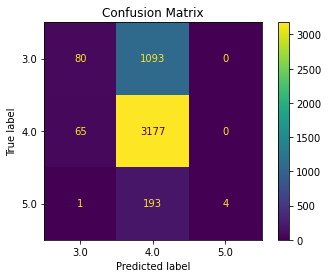

0.7106004769130717


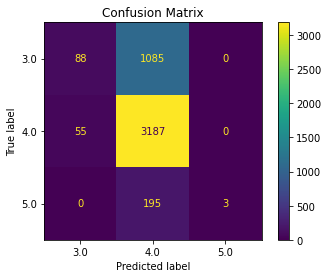

0.7071320182094082


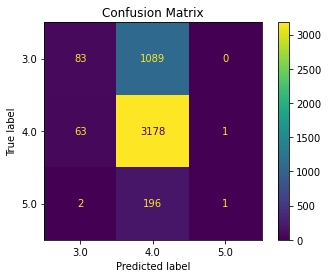

0.705767562879445


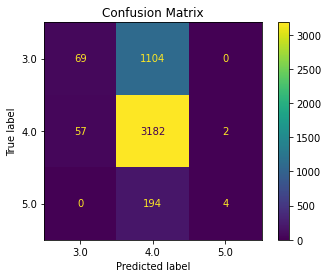

0.704683434518647


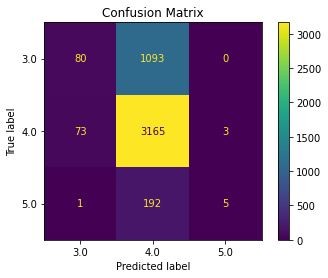

              precision    recall  f1-score   support

         3.0       0.56      0.07      0.12      5864
         4.0       0.71      0.98      0.82     16208
         5.0       0.74      0.02      0.03       991

    accuracy                           0.71     23063
   macro avg       0.67      0.36      0.33     23063
weighted avg       0.67      0.71      0.61     23063

0.7070197464122002


In [53]:
# knn using kfold to avoid overfitting
k = 5
kf_CV = StratifiedKFold(n_splits = k, shuffle = True, random_state = 10)

# Scale X data, we scale the data because it helps the algorithm to converge
# and helps the algorithm to not be greedy with large values, here mainly the
# page numbers are scaled
accuracy = []
all_y_predictions = []
all_y_test = []
scaler = StandardScaler()
scaler.fit(df_train)
scaled_df = scaler.transform(df_train)

# Enter a loop to run K folds of cross-validation
for train_idx, test_idx in kf_CV.split(scaled_df, y_train):
    # train-test split
    X_train, X_test = scaled_df[train_idx], scaled_df[test_idx]
    Y_train, Y_test = y_train[train_idx], y_train[test_idx]

    # hyperparameters here refer to the GridSearchCV in sklearn, later
    # discussed in report
    model = KNeighborsClassifier(n_neighbors=27, weights='distance')
    trained_model = model.fit(X_train, Y_train)
    y_pred_knn = trained_model.predict(X_test)
    all_y_predictions.extend(y_pred_knn)
    all_y_test.extend(Y_test)
    accuracy.append(trained_model.score(X_test, Y_test))
    print(accuracy[-1])

    # plot the confusion metrix of each prediciton
    cm = confusion_matrix(Y_test, # test data
                      y_pred_knn, # predictions
                      labels=sorted(list(y_train.unique())) # class labels from the knn model
                     )

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, # pass through the created confusion matrix
                              display_labels=sorted(list(y_train.unique())) # class labels from the knn model 
                             )

    disp.plot()

    plt.title("Confusion Matrix")
    plt.show()

print(classification_report(all_y_test, all_y_predictions))
print(np.mean(accuracy))

In [54]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

In [55]:
preds = model.predict(scaled_test)
submission_df = pd.Series(preds)
submission_df.index = submission_df.index + 1
submission_df.to_csv('knn_results.csv', index_label='id', header=['rating_label'])

In [56]:
submission_df.value_counts()

4.0    5708
3.0      52
5.0       6
dtype: int64

5.3 Stacking

In [49]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_train)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_df, y_train, test_size=0.9, stratify=y_train, random_state=30027)

In [ ]:
# Define the objective function, not used in our project
def objective_function(C):
    # Instantiate the LinearSVC classifier with the hyperparameter
    svm = LinearSVC(C=C, max_iter=10000)  # Increase max_iter
    
    # Perform cross-validation and calculate the mean accuracy
    accuracy = cross_val_score(svm, X_train, Y_train, cv=5).mean()
    
    # Return the negative accuracy since Bayesian optimization maximizes the objective function
    return -accuracy

# Define the bounds of the search space
pbounds = {'C': (0.001, 5)}

# Create an instance of the BayesianOptimization class
optimizer = BayesianOptimization(f=objective_function, pbounds=pbounds)

# Set the number of iterations or maximum number of function evaluations
optimizer.maximize(init_points=5, n_iter=10)

# Get the best result
best_result = optimizer.max

print("Best parameter C:", best_result['params']['C'])
print("Best negative accuracy:", -best_result['target'])

|   iter    |  target   |     C     |
-------------------------------------


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [51]:
from sklearn.metrics import accuracy_score
class StackingClassifier():

    def __init__(self, classifiers, metaclassifier):
        self.classifiers = classifiers
        self.metaclassifier = metaclassifier

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)
        X_meta = self._predict_base(X) #X_meta is the output (y_hat) of the base classifiers
        self.metaclassifier.fit(X_meta, y) #output of the base classifiers is the input for the meta classifier
    
    def _predict_base(self, X):
        yhats = []
        for clf in self.classifiers:
            yhat = clf.predict_proba(X)
            yhats.append(yhat)
        yhats = np.concatenate(yhats, axis=1)
        assert yhats.shape[0] == X.shape[0] # check that the number of rows yhats matches the number of rows in the input data X
        return yhats
    
    def predict(self, X):
        X_meta = self._predict_base(X)     
        yhat = self.metaclassifier.predict(X_meta)
        return yhat
    def score(self, X, y):
        yhat = self.predict(X)
        return accuracy_score(y, yhat)

In [52]:
# stacking 
classifiers = [DummyClassifier(strategy='most_frequent'),
          KNeighborsClassifier(n_neighbors=27, weights='distance'),
          LogisticRegression(max_iter=1000, C=0.001)]

titles = ['Zero_R',
          '27-nearest neighbour',
          'Logistic Regression']

param_grid = {# 'LinearSVC__C': [1, 0.1, 0.01, 10],
               'final_estimator__n_neighbors': (5, 10)}

meta_classifier_knn = KNeighborsClassifier(n_neighbors = 33, weights='distance')
stacker_knn = StackingClassifier(classifiers, meta_classifier_knn)

# meta_classifier_lgr = LogisticRegression()
# stacker_lgr = StackingClassifier(estimators=list(zip(titles, classifiers)), final_estimator=meta_classifier_lgr, cv=5)

In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

In [ ]:
# stacking using k fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(scaled_df, y_train):
# Split the data into training and testing sets
    X_train, X_test = scaled_df[train_index], scaled_df[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]

    for title, clf in zip(titles,classifiers):
        clf.fit(X_train,Y_train)
        print(title, "Accuracy:",clf.score(X_test,Y_test))

    stacker_knn.fit(X_train, Y_train)
    print('\nStacker Accuracy (KNN):', stacker_knn.score(X_test, Y_test))

Zero_R Accuracy: 0.7027964448298287
27-nearest neighbour Accuracy: 0.709299804899198
Logistic Regression Accuracy: 0.7060481248645133

Stacker Accuracy (KNN): 0.709299804899198
Zero_R Accuracy: 0.7027964448298287
27-nearest neighbour Accuracy: 0.7056145675265554
Logistic Regression Accuracy: 0.6993279861261652

Stacker Accuracy (KNN): 0.7056145675265554
Zero_R Accuracy: 0.7027964448298287
27-nearest neighbour Accuracy: 0.7056145675265554
Logistic Regression Accuracy: 0.6982440927812703

Stacker Accuracy (KNN): 0.7053977888575764
Zero_R Accuracy: 0.7027320034692107
27-nearest neighbour Accuracy: 0.7064180398959237
Logistic Regression Accuracy: 0.7049002601908065

Stacker Accuracy (KNN): 0.7066348655680833
Zero_R Accuracy: 0.7027320034692107
27-nearest neighbour Accuracy: 0.7079358196010408
Logistic Regression Accuracy: 0.7109713790112749

Stacker Accuracy (KNN): 0.7079358196010408


In [ ]:
preds = stacker_knn.predict(scaled_test)
submission_df = pd.Series(preds)
submission_df.value_counts()
submission_df.index = submission_df.index + 1
submission_df.to_csv('submit.csv', index_label='id', header=['rating_label'])

In [ ]:
submission_df.value_counts()

4.0    5703
3.0      55
5.0       8
dtype: int64

In [ ]:
# train test split used to draw the correlation matrix
X_train, X_test, Y_train, Y_test = train_test_split(scaled_df, y_train, test_size=0.2, stratify=y_train, random_state=30027)
predictions = {}
for title,clf in zip(titles,classifiers):
    clf.fit(X_train,Y_train)
    prediction = clf.predict(X_test)
    predictions[title] = prediction
    print(title, "Accuracy:",clf.score(X_test,Y_test))

base_df = pd.DataFrame(predictions)
    
stacker_knn.fit(X_train, Y_train)
print('\nStacker Accuracy (KNN):', stacker_knn.score(X_test, Y_test))

Zero_R Accuracy: 0.7027964448298287
27-nearest neighbour Accuracy: 0.7064816822024713
Logistic Regression Accuracy: 0.7069152395404292

Stacker Accuracy (KNN): 0.7062649035334922


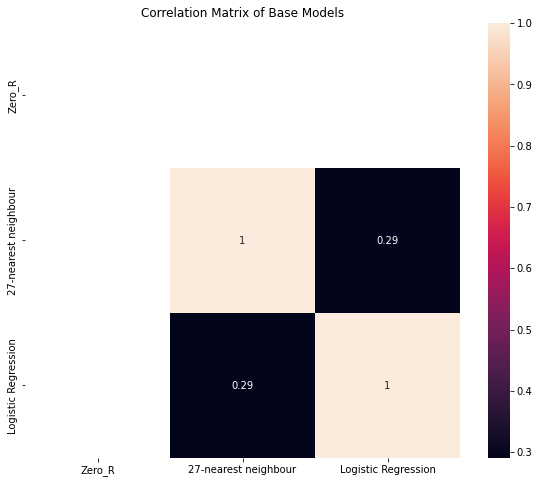

In [ ]:
correlation_matrix = base_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, square=True)
plt.title("Correlation Matrix of Base Models")
plt.show()